In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline


In [5]:
DATA_ROOT = "retina/Data"
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, "train", "image")
TRAIN_MASK_DIR = os.path.join(DATA_ROOT, "train", "mask")
TEST_IMG_DIR = os.path.join(DATA_ROOT, "test", "image")
TEST_MASK_DIR = os.path.join(DATA_ROOT, "test", "mask")

# Gather file paths
train_image_paths = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, "*.*")))
train_mask_paths = sorted(glob.glob(os.path.join(TRAIN_MASK_DIR, "*.*")))

test_image_paths = sorted(glob.glob(os.path.join(TEST_IMG_DIR, "*.*")))
test_mask_paths = sorted(glob.glob(os.path.join(TEST_MASK_DIR, "*.*")))

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of testing images: {len(test_image_paths)}")
print(f"Number of testing masks: {len(test_mask_paths)}")


Number of training images: 80
Number of training masks: 80
Number of testing images: 20
Number of testing masks: 20


In [7]:
def load_image(img_path):
    # Using OpenCV
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_mask(mask_path):
    # Using OpenCV (grayscale)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # If needed, threshold the mask to ensure binary
    _, mask_bin = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
    return mask_bin


In [8]:
image_shapes = []
mask_shapes = []

for img_path, msk_path in zip(train_image_paths, train_mask_paths):
    img = load_image(img_path)
    msk = load_mask(msk_path)
    
    image_shapes.append(img.shape)  # (height, width, channels)
    mask_shapes.append(msk.shape)   # (height, width)
    
# Convert to numpy arrays for easier handling
image_shapes = np.array(image_shapes)
mask_shapes = np.array(mask_shapes)

print("Number of Train Images:", len(image_shapes))
print("Unique Image Shapes in Training Set:", np.unique(image_shapes, axis=0))
print("Unique Mask Shapes in Training Set:", np.unique(mask_shapes, axis=0))

# Repeat similarly for test images if desired


Number of Train Images: 80
Unique Image Shapes in Training Set: [[512 512   3]]
Unique Mask Shapes in Training Set: [[512 512]]


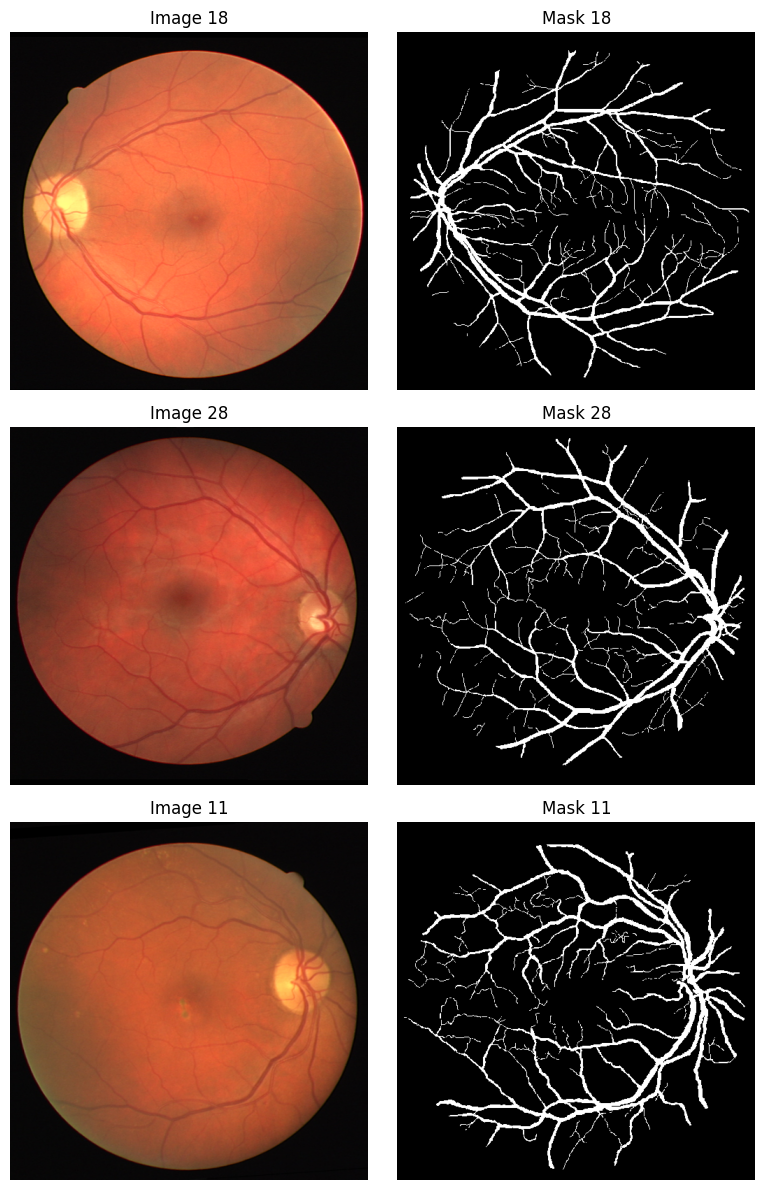

In [9]:
import random

def show_random_samples(num_samples=3):
    selected_indices = random.sample(range(len(train_image_paths)), num_samples)
    
    fig, axs = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))
    for i, idx in enumerate(selected_indices):
        img = load_image(train_image_paths[idx])
        msk = load_mask(train_mask_paths[idx])
        
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f"Image {idx}")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(msk, cmap='gray')
        axs[i, 1].set_title(f"Mask {idx}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

show_random_samples(num_samples=3)


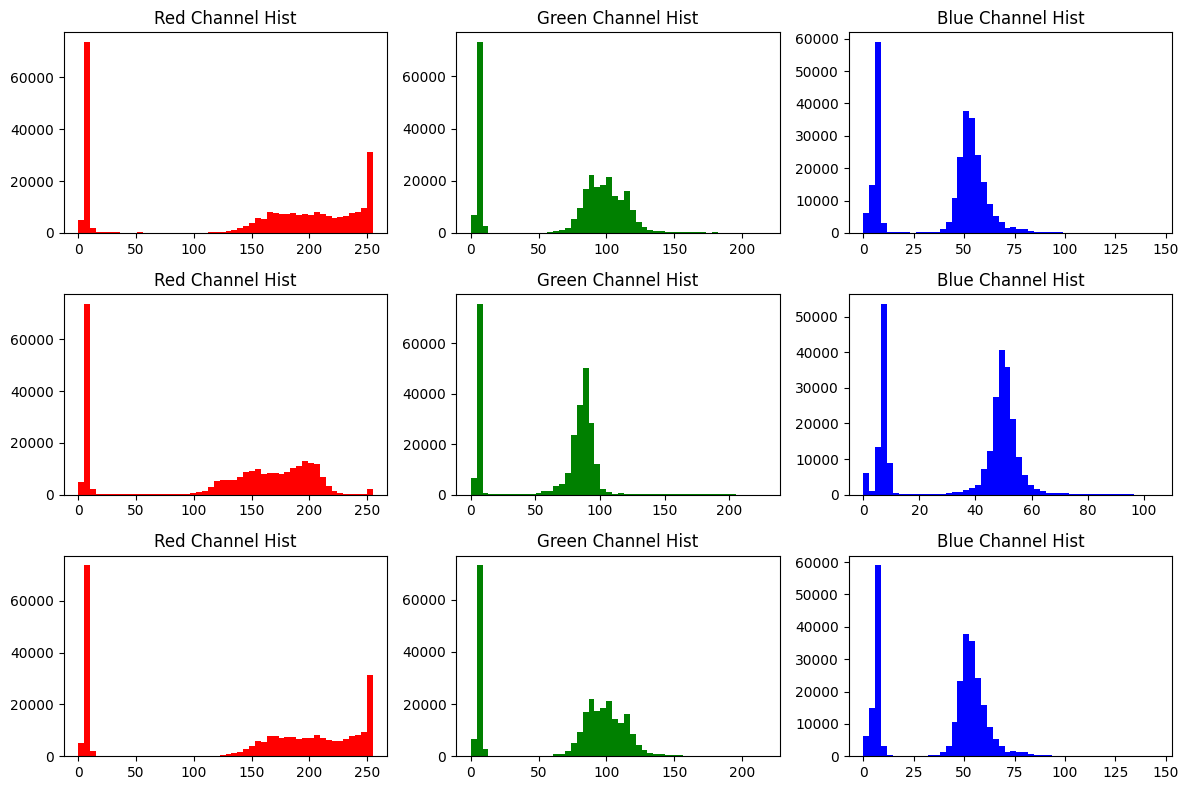

In [10]:
def plot_intensity_histograms(image_paths, num_samples=5):
    """
    Plot histograms of pixel intensities for a random subset of images.
    """
    selected_paths = random.sample(image_paths, num_samples)
    
    plt.figure(figsize=(12, 8))
    for i, path in enumerate(selected_paths):
        img = load_image(path)
        
        # Flatten each channel
        r_vals = img[:,:,0].flatten()
        g_vals = img[:,:,1].flatten()
        b_vals = img[:,:,2].flatten()
        
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.hist(r_vals, bins=50, color='red')
        plt.title("Red Channel Hist")
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.hist(g_vals, bins=50, color='green')
        plt.title("Green Channel Hist")
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.hist(b_vals, bins=50, color='blue')
        plt.title("Blue Channel Hist")
        
    plt.tight_layout()
    plt.show()

plot_intensity_histograms(train_image_paths, num_samples=3)


In [11]:
vessel_proportions = []

for msk_path in train_mask_paths:
    msk = load_mask(msk_path)
    total_pixels = msk.size
    vessel_pixels = np.sum(msk)  # since vessel pixels are 1
    vessel_proportions.append(vessel_pixels / total_pixels)

vessel_proportions = np.array(vessel_proportions)

print("Average vessel proportion:", np.mean(vessel_proportions))
print("Standard deviation of vessel proportion:", np.std(vessel_proportions))


Average vessel proportion: 0.08737101554870605
Standard deviation of vessel proportion: 0.012832648386904566


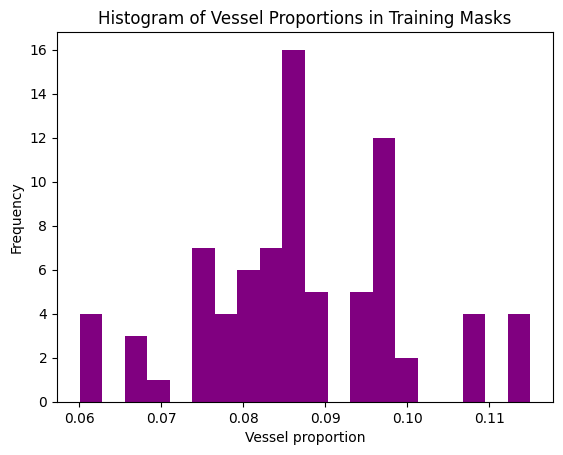

In [12]:
plt.hist(vessel_proportions, bins=20, color='purple')
plt.title("Histogram of Vessel Proportions in Training Masks")
plt.xlabel("Vessel proportion")
plt.ylabel("Frequency")
plt.show()


In [13]:
mismatched_shapes = []
for i, (img_path, msk_path) in enumerate(zip(train_image_paths, train_mask_paths)):
    img = load_image(img_path)
    msk = load_mask(msk_path)
    if img.shape[:2] != msk.shape:
        mismatched_shapes.append((img_path, msk_path, img.shape, msk.shape))

if len(mismatched_shapes) > 0:
    print("Found mismatched shape pairs:")
    for item in mismatched_shapes:
        print(item)
else:
    print("All train image-mask pairs have matching shapes.")


All train image-mask pairs have matching shapes.


In [14]:
def dice_coefficient(pred_mask, true_mask):
    """
    pred_mask and true_mask should be binary arrays (0 or 1).
    """
    pred_mask = pred_mask.flatten()
    true_mask = true_mask.flatten()
    
    intersection = np.sum(pred_mask * true_mask)
    union = np.sum(pred_mask) + np.sum(true_mask)
    if union == 0:
        return 1.0  # If there are no foreground pixels in both, define Dice as 1
    return 2.0 * intersection / union

# Example usage if you had some baseline predictions:
# pred_example = np.zeros_like(true_mask_example)  # A dummy prediction
# dice_value = dice_coefficient(pred_example, true_mask_example)
# print("Dice Coefficient:", dice_value)
